# 导入库

In [1]:
# -*- coding: utf-8 -*-
from __future__ import annotations

# ── 标准库 ──────────────────────────────────────────────────────────────────
import os
import time
from pathlib import Path
from collections import defaultdict
from datetime import datetime
import re

# ── 第三方 ──────────────────────────────────────────────────────────────────
import numpy as np
import pandas as pd
import polars as pl

import gc

import torch
import torch.backends.cudnn as cudnn
import lightning as L
import lightning.pytorch as lp
from torch.utils.data import DataLoader, RandomSampler

from lightning.pytorch.callbacks import EarlyStopping, ModelCheckpoint, LearningRateMonitor
from lightning.pytorch.loggers import TensorBoardLogger
from lightning.pytorch.callbacks import DeviceStatsMonitor
from pytorch_forecasting import TimeSeriesDataSet, TemporalFusionTransformer, Baseline
from pytorch_forecasting.metrics import MAE, RMSE, MAPE, SMAPE, QuantileLoss
from pytorch_forecasting.data.encoders import NaNLabelEncoder
from pytorch_forecasting.data import TorchNormalizer, GroupNormalizer


# 你的工程工具
from pipeline.io import cfg, P, fs, storage_options, ensure_dir_local, ensure_dir_az
from pipeline.stream_input_local import ShardedBatchStream  
from pipeline.wr2 import WR2

# ---- 性能/兼容开关（仅一次）----
os.environ.setdefault("POLARS_MAX_THREADS", str(max(1, os.cpu_count() // 2)))
pl.enable_string_cache()
cudnn.benchmark = True
torch.set_float32_matmul_precision("high")

import time as _t


import warnings
warnings.filterwarnings("ignore")  # avoid printing out absolute paths

def _now() -> str:
    return _t.strftime("%Y-%m-%d %H:%M:%S")
print(f"[{_now()}] imports ok")

/home/admin_ml/Jackson/projects/js/JS/.venv/lib/python3.10/site-packages/pytorch_forecasting/models/base/_base_model.py:28: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm


[2025-10-23 15:18:06] imports ok


# 定义工具函数

In [2]:
# ───────────────────────────────────────────────────────────────────────────
# 滑动窗划分
def make_sliding_cv_by_days(all_days: np.ndarray, *, n_splits: int, gap_days: int, train_to_val: int):
    all_days = np.asarray(all_days).ravel()
    K, R, G = n_splits, train_to_val, gap_days
    usable = len(all_days) - G
    if usable <= 0 or K <= 0 or R <= 0:
        return []
    V_base, rem = divmod(usable, R + K)
    if V_base <= 0:
        return []
    T = R * V_base
    v_lens = [V_base + 1 if i < rem else V_base for i in range(K)]
    folds, v_lo = [], T + G
    for V_i in v_lens:
        v_hi, tr_hi, tr_lo = v_lo + V_i, v_lo - G, v_lo - G - T
        if tr_lo < 0 or v_hi > len(all_days):
            break
        folds.append((all_days[tr_lo:tr_hi], all_days[v_lo:v_hi]))
        v_lo = v_hi
    return folds


# 初始化参数

In [3]:
start_date, end_date = (1000, 1600)  # 仅用于本次实验

# 读入筛选的所有特征列

path = Path("/mnt/data/js/exp/v1/models/tune/selected_covariant_features.txt")
filted_cols = path.read_text(encoding="utf-8").splitlines()

selected_features = pd.read_csv("/mnt/data/js/exp/v1/models/tune/feature_importance__fixed__fixed__mm_full_train__features__fs__1400-1698__cv2-g7-r4__seed42__top1000__1760906660__range830-1698__range830-1698__cv2-g7-r4__1760912739.csv")

df_cov_cols = selected_features[selected_features['feature'].isin(filted_cols)].copy()

# 我们这里重新归一化一下
df_cov_cols["mean_gain"] = (df_cov_cols['mean_gain'] / df_cov_cols['mean_gain'].sum()).astype(np.float32)
df_e_features = df_cov_cols.reset_index(drop=True)


# ========== 1) 初始化配置 ==========

# 所有列
G_SYM, G_DATE, G_TIME = cfg["keys"]          # e.g. ("symbol_id","date_id","time_id")
TARGET_COL = cfg["target"]                   # e.g. "responder_6"
WEIGHT_COL = cfg["weight"]                   # 允许为 None

TIME_FEATURES = ["time_bucket", "time_pos", "time_sin", "time_cos"]

COV_FEATURES = df_e_features['feature'].iloc[:200].tolist() # 可能含有组内常数列

STATIC_FEATURES = [c for c in COV_FEATURES if c in ["feature_09", "feature_10", "feature_11"]]

CS_RANK_FEATURES = [c for c in COV_FEATURES if c.endswith("__csrank")]

CS_R_Z_FEATURES = [c for c in COV_FEATURES if c.endswith("__cs_z") or c.endswith("__rz")]


do_z_co_cols = [c for c in COV_FEATURES if c not in STATIC_FEATURES + CS_RANK_FEATURES + CS_R_Z_FEATURES]

# 训练 & CV 超参
N_SPLITS     = 2
GAP_DAYS     = 7
TRAIN_TO_VAL = 6
ENC_LEN      = 256
DEC_LEN      = 1
PRED_LEN     = DEC_LEN
BATCH_SIZE   = 64
LR           = 1e-2
HIDDEN       = 16
HEADS        = 1
DROPOUT      = 0.3
MAX_EPOCHS   = 10
GRADIENT_CLIP_VAL = 1.0

# 数据路径
PANEL_DIR_AZ   = P("az", cfg["paths"].get("panel_shards", "panel_shards"))

TFT_LOCAL_ROOT = P("local", "tft"); ensure_dir_local(TFT_LOCAL_ROOT)

LOCAL_CLEAN_DIR = f"{TFT_LOCAL_ROOT}/clean"; ensure_dir_local(LOCAL_CLEAN_DIR)
CKPTS_DIR = Path(TFT_LOCAL_ROOT) / "ckpts"; ensure_dir_local(CKPTS_DIR.as_posix())
LOGS_DIR  = Path(TFT_LOCAL_ROOT) / "logs";  ensure_dir_local(LOGS_DIR.as_posix())


print("[config] ready")


[config] ready


# 导入数据，添加全局time_idx

In [ ]:
data_paths = fs.glob("az://jackson/js_exp/exp/v1/panel_shards/*.parquet")
data_paths =[f"az://{p}" for p in data_paths]

lf_data = (
    pl.scan_parquet(data_paths, storage_options=storage_options)
    .select([*cfg['keys'], WEIGHT_COL, TARGET_COL, *TIME_FEATURES, *COV_FEATURES])
    .filter(pl.col(G_DATE).is_between(start_date, end_date, closed="both"))
)
lf_data = lf_data.sort([G_SYM, G_DATE, G_TIME])


# 先归一化time_pos
lf_data = lf_data.with_columns(
    (pl.col("time_pos") / pl.lit(968)).cast(pl.Float32).alias("time_pos")
)

In [ ]:
lf_data.limit(10).collect()  # 触发计算

In [ ]:
grid_df = (
    lf_data.select([G_DATE, G_TIME]).unique()
        .sort([G_DATE, G_TIME])
        .with_row_index("time_idx")
        .with_columns(pl.col("time_idx").cast(pl.Int64))
        .collect(streaming=True)
)

container_prefix = "az://jackson/js_exp/exp/v1/tft/panel_clean_shards"; ensure_dir_az(container_prefix)
chunk_size = 30
for lo in range(start_date, end_date + 1, chunk_size):
    hi = min(lo + chunk_size - 1, end_date)
    print(f"processing date range: {lo} ~ {hi}")
    
    lf_chunk = lf_data.filter(pl.col(G_DATE).is_between(lo, hi, closed="both"))
    
    lf_grid_chunk = (
        grid_df.lazy().filter(pl.col(G_DATE).is_between(lo, hi, closed="both"))
    )
    
    lf_joined = (
        lf_chunk.join(lf_grid_chunk, on=[G_DATE, G_TIME], how="left").sort([G_SYM, "time_idx"])
    )
    
    out_path = f"{container_prefix}/panel_clean_{lo:04d}_{hi:04d}.parquet"
    print(f"writing to: {out_path}")
    
    lf_joined.sink_parquet(
        out_path,
        storage_options=storage_options,
        compression="zstd",
    )
    
del lf_data, lf_chunk, lf_grid_chunk, lf_joined; gc.collect()
print(f"[{_now()}] all done")

# 重新导入含有time_idx的数据 & CV 划分

In [4]:
container_prefix = "az://jackson/js_exp/exp/v1/tft/panel_clean_shards"
data_paths = fs.glob(f"{container_prefix}/*.parquet")
data_paths = [f"az://{p}" for p in data_paths] 
lf_with_idx = pl.scan_parquet(data_paths, storage_options=storage_options).filter(pl.col(G_DATE).is_between(start_date, end_date, closed="both")).sort([G_SYM, "time_idx"])

In [5]:
# ==========  CV 划分 ==========
all_days = (
    lf_with_idx.select(pl.col(G_DATE)).unique().sort([G_DATE])
    .collect(streaming=True)[G_DATE].to_numpy()
)
folds_by_day = make_sliding_cv_by_days(all_days, n_splits=N_SPLITS, gap_days=GAP_DAYS, train_to_val=TRAIN_TO_VAL)

print(f"[cv] total {len(folds_by_day)} folds")

assert len(folds_by_day) > 0, "no CV folds constructed"
print(folds_by_day)

[cv] total 2 folds
[(array([1000, 1001, 1002, 1003, 1004, 1005, 1006, 1007, 1008, 1009, 1010,
       1011, 1012, 1013, 1014, 1015, 1016, 1017, 1018, 1019, 1020, 1021,
       1022, 1023, 1024, 1025, 1026, 1027, 1028, 1029, 1030, 1031, 1032,
       1033, 1034, 1035, 1036, 1037, 1038, 1039, 1040, 1041, 1042, 1043,
       1044, 1045, 1046, 1047, 1048, 1049, 1050, 1051, 1052, 1053, 1054,
       1055, 1056, 1057, 1058, 1059, 1060, 1061, 1062, 1063, 1064, 1065,
       1066, 1067, 1068, 1069, 1070, 1071, 1072, 1073, 1074, 1075, 1076,
       1077, 1078, 1079, 1080, 1081, 1082, 1083, 1084, 1085, 1086, 1087,
       1088, 1089, 1090, 1091, 1092, 1093, 1094, 1095, 1096, 1097, 1098,
       1099, 1100, 1101, 1102, 1103, 1104, 1105, 1106, 1107, 1108, 1109,
       1110, 1111, 1112, 1113, 1114, 1115, 1116, 1117, 1118, 1119, 1120,
       1121, 1122, 1123, 1124, 1125, 1126, 1127, 1128, 1129, 1130, 1131,
       1132, 1133, 1134, 1135, 1136, 1137, 1138, 1139, 1140, 1141, 1142,
       1143, 1144, 1145, 1146,

# 接下来均已第一折为例

In [6]:
fold_id = 0
# 取第一个 fold 的训练集最后一天，作为本折统计 z-score 的上界
train_lo, train_hi = folds_by_day[fold_id][0][0], folds_by_day[fold_id][0][-1]
val_lo, val_hi = folds_by_day[fold_id][1][0], folds_by_day[fold_id][1][-1]

print(f"统计标准化使用训练集的日期范围 = {train_lo} ~ {train_hi}")
print(f"验证集日期范围 = {val_lo} ~ {val_hi}")

统计标准化使用训练集的日期范围 = 1000 ~ 1443
验证集日期范围 = 1451 ~ 1525


# 数据处理

## 填补因为特征工程产生的缺失列

In [ ]:
# 计算训练集的各特征量的中位数
lf_tr = lf_with_idx.filter(pl.col(G_DATE).is_between(train_lo, train_hi, closed="both"))

grp_median = (
    lf_tr
    .group_by([G_SYM, "time_pos"])
    .agg([
        pl.col(col).median().alias(f"{col}_median_st") for col in COV_FEATURES
    ])
    .sort([G_SYM, "time_pos"])
)

glb_median = (
    lf_tr
    .group_by("time_pos")
    .agg([
        pl.col(col).median().alias(f"{col}_median_t") for col in COV_FEATURES
    ])
    .sort("time_pos")
)

# 应用于本折全部数据 trian + val
lf_all = lf_with_idx.join(grp_median, on=[G_SYM, "time_pos"], how="left").join(glb_median, on=["time_pos"], how="left").sort([G_SYM, "time_idx"])

# 逐列用中位数替换缺失值
fill_exprs = []

for col in COV_FEATURES:
    fill_exprs.append(
        pl.coalesce([
            pl.col(col),
            pl.col(f"{col}_median_st"),
            pl.col(f"{col}_median_t")
        ]).alias(col)
    )

lf_all_imputed = lf_all.with_columns(fill_exprs)

# 去掉中位数列
drop_cols = [f"{col}_median_st" for col in COV_FEATURES]
drop_cols += [f"{col}_median_t" for col in COV_FEATURES]
lf_all_imputed = lf_all_imputed.drop(drop_cols)


In [ ]:
if False:   
    df_null_lf_all_imputed = lf_all_imputed.select(
        pl.all().null_count()
    ).collect().to_pandas().T.sort_values(by=0, ascending=False)

    assert df_null_lf_all_imputed.iloc[0,0] == 0, "仍有缺失值未填补完成！"

    del lf_tr, grp_median, glb_median, lf_all, df_null_lf_all_imputed; gc.collect()

del lf_tr, grp_median, glb_median, lf_all; gc.collect()

## 静态特征归一化

In [ ]:
lf_tr_imputed = lf_all_imputed.filter(pl.col(G_DATE).is_between(train_lo, train_hi, closed="both"))

static_glb_minmax = (
    lf_tr_imputed.select(
        *[pl.col(c).min().alias(f"{c}_min") for c in STATIC_FEATURES],
        *[pl.col(c).max().alias(f"{c}_max") for c in STATIC_FEATURES],
    ).collect().to_dicts()[0]   # ← 用 to_dicts()[0]
)

eps = 1e-8

lf_all = lf_all_imputed.with_columns([
    (
        ((pl.col(c) - pl.lit(static_glb_minmax[f"{c}_min"])) /
         (pl.lit(static_glb_minmax[f"{c}_max"] - static_glb_minmax[f"{c}_min"]) + eps))
        .clip(0.0, 1.0)
    ).cast(pl.Float32).alias(c)   # ← cast/alias 作用于“整个结果”
    for c in STATIC_FEATURES
])

# 不需要 drop（你没创建 *_glb_min/_glb_max 列）
del lf_tr_imputed, static_glb_minmax; gc.collect()


## 标准化

In [ ]:
# ========== Z-score ==========
# 计算 训练集 stats

lf_tr = lf_all.filter(pl.col(G_DATE).is_between(train_lo, train_hi, closed="both"))
grp_stats = (
    lf_tr
    .group_by(G_SYM)
    .agg([pl.col(c).mean().alias(f"mu_grp_{c}") for c in do_z_co_cols] +
        [pl.col(c).std().alias(f"std_grp_{c}") for c in do_z_co_cols])
).collect(streaming=True)

glb_stats = (
    lf_tr
    .select([pl.col(c).mean().alias(f"mu_glb_{c}") for c in do_z_co_cols] +
            [pl.col(c).std().alias(f"std_glb_{c}") for c in do_z_co_cols])
).collect(streaming=True)


In [ ]:
import math

glb_row = glb_stats.to_dicts()[0]

# 逐日标准化本折所有数据并保存
fold_root = f"az://jackson/js_exp/exp/v1/tft/fold_{fold_id}"; ensure_dir_az(fold_root)
z_prefix = f"{fold_root}/z_shards"; ensure_dir_az(z_prefix)

z_done_cols = [f"z_{c}" for c in (do_z_co_cols)]
min_std = 1e-5
eps = 1e-8

# 预处理全局均值/方差的兜底，避免在行级判断
glb_mu = {c: glb_row[f"mu_glb_{c}"] for c in do_z_co_cols}
glb_std = {}
for c in do_z_co_cols:
    s = glb_row[f"std_glb_{c}"]
    if s is None or s <= 0:
        s = min_std
    glb_std[c] = s

for d in range(train_lo, val_hi + 1):
    lf_day = lf_all.filter(pl.col(G_DATE) == d)

    lf_day_z = lf_day.join(grp_stats.lazy(), on=G_SYM, how="left").sort([G_SYM, "time_idx"])

    # 1) 先把所有“常量”变成具名列，避免 anonymous literal
    const_exprs = []
    for c in do_z_co_cols:
        const_exprs += [
            pl.lit(glb_mu[c]).alias(f"__mu_glb_{c}"),
            pl.lit(glb_std[c] if glb_std[c] > 0 else min_std).alias(f"__std_glb_{c}"),
        ]
    lf_day_z = lf_day_z.with_columns(const_exprs)

    # 2) 计算 z，并用 clip 裁剪
    exprs = []
    for c in do_z_co_cols:
        mu_grp  = pl.col(f"mu_grp_{c}")
        std_grp = pl.col(f"std_grp_{c}")
        mu_use = pl.coalesce([mu_grp, pl.col(f"__mu_glb_{c}")]).cast(pl.Float32)

        std_tmp = pl.when(std_grp.is_null() | (std_grp <= 0))\
                    .then(pl.col(f"__std_glb_{c}"))\
                    .otherwise(std_grp)
        std_use = pl.when(std_tmp < min_std).then(min_std).otherwise(std_tmp).cast(pl.Float32)

        z = ((pl.col(c).cast(pl.Float32) - mu_use) / (std_use + eps)).clip(-3.0, 3.0).alias(f"z_{c}")
        exprs.append(z)

    lf_day_z = lf_day_z.with_columns(exprs)
    
    keep = [
        "time_idx", G_SYM, G_DATE, G_TIME, WEIGHT_COL, TARGET_COL
    ] + TIME_FEATURES + STATIC_FEATURES + CS_RANK_FEATURES + CS_R_Z_FEATURES + z_done_cols
        

    # 去重但保持顺序（避免 DuplicateError）
    keep = list(dict.fromkeys(keep))
    
    lf_out = lf_day_z.select(keep).sort([G_SYM, "time_idx"])

    out_path = f"{z_prefix}/z_{d:04d}.parquet"
    lf_out.collect(streaming=True).write_parquet(
        out_path, storage_options=storage_options, compression="zstd"
    )
    print(f"wrote z-scored data for day {d} to {out_path}")

In [ ]:
del lf_tr, grp_stats, glb_stats; gc.collect()
del lf_day_z, lf_all; gc.collect()

# 模型训练

In [7]:
lp.seed_everything(42) 

z_done_cols = [f"z_{c}" for c in do_z_co_cols]

# 明确输入的各列
known_varying_categorical_cols = ["time_bucket", "gap_flag"] # gap_flag 需要后续添加

known_varying_reals_cols = ["time_pos", "time_sin", "time_cos"] + STATIC_FEATURES + CS_RANK_FEATURES + CS_R_Z_FEATURES + z_done_cols
unscaler_cols = known_varying_reals_cols

TRAIN_COLS = [G_SYM, G_DATE, G_TIME, "time_idx", WEIGHT_COL, TARGET_COL] + known_varying_categorical_cols + known_varying_reals_cols 

print(f"weight col: {WEIGHT_COL}")
print(f"target cols: {TARGET_COL}")
print(f"encode length: {ENC_LEN}, pred length: {PRED_LEN}")
print(f"input varying_reals_cols: {known_varying_reals_cols}")
print(f"input varying_categorical_cols: {known_varying_categorical_cols}")


# 导入 本折z-score 后的数据进行后续处理
fold_root = f"az://jackson/js_exp/exp/v1/tft/fold_{fold_id}"
z_prefix = f"{fold_root}/z_shards"

data_paths = fs.glob(f"{z_prefix}/*.parquet")
data_paths = [f"az://{p}" for p in data_paths]
lf = pl.scan_parquet(data_paths, storage_options=storage_options).sort([G_SYM, "time_idx"])

# 添加 gap_flag 列
# 只保留 symbol×date 唯一组合并排序
lf_grp_date = (
    lf.select([pl.col(G_SYM), pl.col(G_DATE)])
      .unique()
      .sort([G_SYM, G_DATE])
)

lf_gap = lf_grp_date.with_columns(
    pl.col(G_DATE).diff().over(G_SYM).fill_null(1).alias("date_diff")
).with_columns(
    (pl.col("date_diff") > 1).cast(pl.Int8).alias("gap_flag")
).select(
    G_SYM, G_DATE, "gap_flag"
).sort([G_SYM, G_DATE])


lf = lf.join(lf_gap, on=[G_SYM, G_DATE], how="left").sort([G_SYM, "time_idx"])
del lf_grp_date, lf_gap; gc.collect()

Seed set to 42


weight col: weight
target cols: responder_6
encode length: 256, pred length: 1
input varying_reals_cols: ['time_pos', 'time_sin', 'time_cos', 'feature_09', 'feature_11', 'feature_60__csrank', 'feature_26__csrank', 'feature_60__cs_z', 'feature_59__cs_z', 'z_feature_06', 'z_feature_36', 'z_feature_04', 'z_feature_59__rstd30', 'z_feature_07', 'z_feature_61__ret50', 'z_feature_31__lag4840', 'z_feature_61__lag7744', 'z_feature_61__diff50', 'z_feature_51__ewm10', 'z_feature_61__lag1936', 'z_feature_59__ewm5', 'z_feature_48', 'z_feature_61__lag900', 'z_feature_59', 'z_feature_51__rmean14', 'z_feature_31__diff50', 'z_feature_04__ewm5', 'z_feature_61__lag3872', 'z_feature_04__ewm10', 'z_feature_06__rz30', 'z_feature_60__rstd30', 'z_feature_54__ewm10', 'z_feature_37__rstd30', 'z_feature_22__diff50', 'z_feature_30__lag50', 'z_feature_01__ewm50', 'z_feature_61__lag4840', 'z_feature_61__lag2904', 'z_responder_2_prev_tail_lag10', 'z_feature_26__lag900', 'z_feature_08__ewm50', 'z_feature_20__diff50',

7426

In [19]:
# 先只取一个symbol训练

lf = lf.select(TRAIN_COLS)
lf = lf.filter(pl.col(G_SYM) == 0)

df = lf.collect(streaming=True).to_pandas()


df[G_SYM] = df[G_SYM].astype(str).astype("category")

# 确保 pandas dtypes
df["time_bucket"] = df["time_bucket"].astype(str).astype("category")
df["gap_flag"] = df["gap_flag"].astype(str).astype("category")

for c in known_varying_reals_cols:
    df[c] = df[c].astype(np.float32)

    
df[TARGET_COL] = df[TARGET_COL].astype(np.float32)
df[WEIGHT_COL] = df[WEIGHT_COL].astype(np.float32)

df.sort_values(by=[G_SYM, "time_idx"], inplace=True)


train_start_idx = df[df[G_DATE] == train_lo]["time_idx"].min()
train_end_idx   = df[df[G_DATE] == train_hi]["time_idx"].max()
val_start_idx   = df[df[G_DATE] == val_lo]["time_idx"].min()
val_end_idx     = df[df[G_DATE] == val_hi]["time_idx"].max()

df_train = df.loc[df.time_idx.between(train_start_idx, train_end_idx)].copy()

warmup_len = ENC_LEN
df_val_ctx   = df.loc[df.time_idx.between(val_start_idx-warmup_len, val_end_idx)].copy()

df_train["time_idx"] = df_train["time_idx"].astype("int64")
df_val_ctx["time_idx"]   = df_val_ctx["time_idx"].astype("int64")

## 核查数据是否适合训练

In [ ]:
print("总行数:", len(df))
print("训练/验证行数:", len(df_train), len(df_val_ctx))
print("分组数:", df[G_SYM].nunique())
print("训练集分组数:", df_train[G_SYM].nunique())
print("验证集分组数:", df_val_ctx[G_SYM].nunique())
print("日期范围:", df[G_DATE].min(), "→", df[G_DATE].max())

# 关键键是否唯一（防重复）
dup_keys = df.duplicated(subset=[G_SYM, "time_idx"], keep=False).sum()
print("重复 (sym, time_idx) 行数:", dup_keys)
assert dup_keys == 0, "发现 (sym, time_idx) 重复，请先去重！"



In [ ]:
# 目标/权重合法性
print("目标缺失/非有限:", (~np.isfinite(df[TARGET_COL])).sum())
print("权重缺失/非有限:", (~np.isfinite(df[WEIGHT_COL])).sum())
print("权重负值行数:", (df[WEIGHT_COL] < 0).sum())

# 特征缺失
na_counts = df[known_varying_reals_cols].isna().sum().sort_values(ascending=False)
print("Top-10 特征缺失：")
print(na_counts.head(10))

# 常数列（无方差，喂模型没意义）
const_cols = []
for c in known_varying_reals_cols:
    s = df[c]
    if s.notna().any() and np.nanstd(s.values.astype(np.float32)) == 0.0:
        const_cols.append(c)
print("常数列数量:", len(const_cols), "示例:", const_cols[:10])

# 极端值（Q0.1%~99.9%之外的占比）
def extreme_ratio(s):
    ql, qh = np.nanpercentile(s.values, [0.1, 99.9])
    return float(((s < ql) | (s > qh)).mean())
extreme_report = {c: extreme_ratio(df[c]) for c in known_varying_reals_cols[:50]}  # 先抽50列看
print("极端值占比（前50列示例）:", sorted(extreme_report.items(), key=lambda x: -x[1])[:10])


In [ ]:
# 每个 symbol 的 gap 比例 & 最大连续缺口
def gap_stats(g):
    gaps = g["gap_flag"].astype(bool).to_numpy()
    gap_ratio = gaps.mean()
    # 估算最大连续 gap 段长度
    # 若 time_idx 连续递增，连续段可用 diff>1 的 run-length 来近似
    d = g["time_idx"].diff().fillna(1).to_numpy()
    max_gap = int(d[d>1].max()) if (d>1).any() else 1
    return pd.Series({"gap_ratio": gap_ratio, "max_gap": max_gap})

gs = df.groupby(G_SYM, observed=True).apply(gap_stats)
print(gs.describe())

# 验证集首个 time_idx 是否有足够 warmup
first_val = df_val_ctx.groupby(G_SYM, observed=True)["time_idx"].min()
need_warmup = (first_val < (val_start_idx - ENC_LEN)).sum()
print("有 warmup 的分组数:", (first_val <= val_start_idx).sum(), "不足 warmup 的分组数:", need_warmup)


In [ ]:
assert train_end_idx < val_start_idx, "训练/验证时间有重叠或倒序，请检查 train_hi/val_lo！"

# 各分组在训练/验证的覆盖情况
cov = pd.DataFrame({
    "train_rows": df_train.groupby(G_SYM, observed=True).size(),
    "val_rows":   df_val_ctx.groupby(G_SYM, observed=True).size(),
}).fillna(0).astype(int)
print("训练/验证覆盖（前10）：")
print(cov.head(10))
bad_groups = cov.query("train_rows < @ENC_LEN or val_rows < 1").index.tolist()
print("潜在不可训练分组数:", len(bad_groups), "示例:", bad_groups[:10])


In [ ]:
print("目标分布:", df[TARGET_COL].describe(percentiles=[.01,.1,.5,.9,.99]))
print("权重分布:", df[WEIGHT_COL].describe(percentiles=[.01,.1,.5,.9,.99]))

# 权重为0的比例（有的赛题权重0表示忽略，需明确）
w0_ratio = (df[WEIGHT_COL] == 0).mean()
print("权重=0 占比:", round(float(w0_ratio), 4))


In [ ]:
# 取最近一段的抽样，避免大表过慢
sample = df.sample(min(500_000, len(df)), random_state=42)

# 简易皮尔逊相关（注意：时序相关不等于可用性，这只是红/绿灯）
corrs = sample[known_varying_reals_cols + [TARGET_COL]].corr(numeric_only=True)[TARGET_COL].sort_values(ascending=False)
print("与目标最相关 Top-15：")
print(corrs.head(15))
print("与目标最负相关 Top-15：")
print(corrs.tail(15))


## 准备训练

In [20]:
train_ds = TimeSeriesDataSet(
    df_train,
    time_idx="time_idx",
    target=TARGET_COL,
    group_ids=[G_SYM],
    weight=WEIGHT_COL,
    min_encoder_length=ENC_LEN,
    max_encoder_length=ENC_LEN,
    min_prediction_length=PRED_LEN,
    max_prediction_length=PRED_LEN,
    
    static_categoricals=[],
    static_reals=[],
    
    time_varying_unknown_categoricals = [],
    time_varying_unknown_reals = [],


    time_varying_known_categoricals=known_varying_categorical_cols,
    time_varying_known_reals=known_varying_reals_cols,
    
    target_normalizer=GroupNormalizer(groups=[G_SYM], method="standard"),
    
    allow_missing_timesteps=True,
    
    scalers= {name: None for name in (unscaler_cols)}
)

val_ds = TimeSeriesDataSet.from_dataset(
    train_ds,
    df_val_ctx,
    min_prediction_idx=val_start_idx,
    predict=False,
    stop_randomization=True,
)


In [21]:

# 配置：每个 epoch 想训练多少个“样本/窗口”
# 任选其一：按比例或固定数量
SAMPLE_FRACTION = 0.1        # 例：每个 epoch 只随机抽取 20% 的窗口
# SAMPLES_PER_EPOCH = 10000  # 或者：固定每个 epoch 抽 1e4 个窗口

# 计算 num_samples（即本 epoch 的样本数）
_train_total = len(train_ds); _val_total = len(val_ds)
num_samples = max(1, int(_train_total * SAMPLE_FRACTION))
# 如果用固定数量就改为：
# num_samples = min(_train_total, SAMPLES_PER_EPOCH)

# 打印epoch 样本数
print(f"train samples: {_train_total}, val samples: {_val_total}")

# 关键：带放回的随机采样器（每个 epoch 都会重新抽样）
train_sampler = RandomSampler(train_ds, replacement=True, num_samples=num_samples)

train_loader = train_ds.to_dataloader(train=True, batch_size=BATCH_SIZE, num_workers=12, pin_memory=True, persistent_workers=True, prefetch_factor=2, shuffle=False,sampler=train_sampler)
val_loader   = val_ds.to_dataloader(train=False, batch_size=BATCH_SIZE*4, num_workers=12, pin_memory=True, persistent_workers=True, prefetch_factor=2, shuffle=False)

del df, df_train, df_val_ctx; gc.collect()

n_train_batches = len(train_loader)
print(f"train_loader batches = {n_train_batches}")
n_val_batches = len(val_loader)
print(f"val_loader batches = {n_val_batches}")

print(f"[{_now()}] data loaders ready")

train samples: 419800, val samples: 68928
train_loader batches = 655
val_loader batches = 270
[2025-10-23 15:48:09] data loaders ready


## 优化学习率

In [12]:
from lightning.pytorch.tuner import Tuner

pl.set_random_seed(42)

# 1) 运行前清理缓存（可选）
torch.cuda.empty_cache()
torch.cuda.reset_peak_memory_stats()

# 2) 给 LR finder 专用的小 batch loader
#    不要动正式的 train_loader/val_loader
# 3) 混合精度（优先 bf16，其次 fp16）
trainer_lr = lp.Trainer(
    accelerator="gpu",
    gradient_clip_val=0.1,
)

# 4) 可选：只为 LR finder 构建一个“轻量化”的 TFT（不影响正式模型）
tft_lr = TemporalFusionTransformer.from_dataset(
    train_ds,
    learning_rate=LR,
    hidden_size=32,             # 降低一点隐藏维度
    attention_head_size=1,       # 降低头数
    hidden_continuous_size=16,
    dropout=0.2,
    loss=QuantileLoss(),
    optimizer="ranger",
)

# 5) 运行 LR finder，限制搜索步数
res = Tuner(trainer_lr).lr_find(
    tft_lr,
    train_dataloaders=train_loader,
    val_dataloaders=val_loader,
    min_lr=1e-6,
    max_lr=1e-1,         
)

💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Finding best initial lr: 100%|██████████| 100/100 [09:34<00:00,  5.75s/it]
Restoring states from the checkpoint path at /home/admin_ml/Jackson/projects/js/JS/.lr_find_dbb94835-07d1-44aa-910a-9bdc46c4ff52.ckpt
Restored all states from the checkpoint at /home/admin_ml/Jackson/projects/js/JS/.lr_find_dbb94835-07d1-44aa-910a-9bdc46c4ff52.ckpt
Learning rate set to 1.1220184543019633e-05


suggested learning rate: 1.1220184543019633e-05


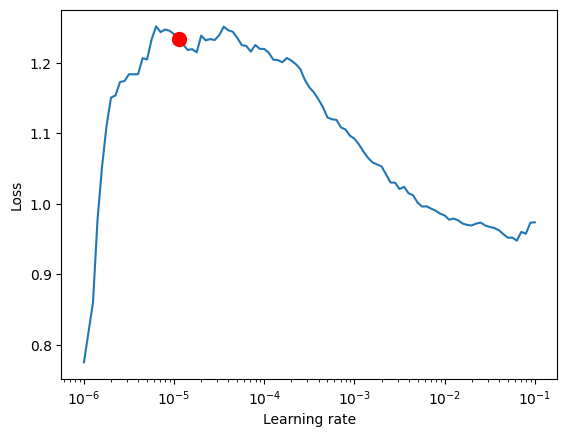

In [13]:

print(f"suggested learning rate: {res.suggestion()}")
fig = res.plot(show=True, suggest=True)
fig.show()

## 正式训练

In [ ]:
LR = 1e-2  # 根据 LR finder 结果调整
HIDDEN = 32
HEADS = 1
DROPOUT = 0.1
MAX_EPOCHS = 5
GCV = 0.1


tft = TemporalFusionTransformer.from_dataset(
    train_ds,
    learning_rate=LR,
    hidden_size=HIDDEN,
    attention_head_size=HEADS,
    dropout=DROPOUT,
    hidden_continuous_size=HIDDEN//2,
    loss=QuantileLoss(quantiles=[0.5]),                            # 点预测 OK，会自动用 weight                     
    optimizer="ranger",
    reduce_on_plateau_patience=1,
    reduce_on_plateau_min_lr=1e-5
)
# 打印模型参数
print(f"fold_id = {fold_id}")
print(f"train_lo = {train_lo}, train_hi = {train_hi}")
print(f"val_lo = {val_lo}, val_hi = {val_hi}")
print(f"target_col = {TARGET_COL}")
print(f"weight_col = {WEIGHT_COL}")
print(f"encode length = {ENC_LEN}, pred length = {PRED_LEN}")
print(f"lr = {LR}, batch size = {BATCH_SIZE}")
print(f"hiden size = {HIDDEN}, heads = {HEADS}, dropout = {DROPOUT}")
print(f"max epochs = {MAX_EPOCHS}")


ckpt_dir_fold = Path(CKPTS_DIR) / f"fold_{fold_id}"
ckpt_dir_fold.mkdir(parents=True, exist_ok=True)

ts = datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
RUN_NAME = f"ranger_lr{LR:g}_bs{BATCH_SIZE}_enc{ENC_LEN}_hidden{HIDDEN}_heads{HEADS}_time_{ts}"
TEMP_LOG_DIR = Path("./tft_logs"); TEMP_LOG_DIR.mkdir(parents=True, exist_ok=True)
logger = TensorBoardLogger(save_dir=TEMP_LOG_DIR.as_posix(),name="tft",version=RUN_NAME,default_hp_metric=False)

callbacks = [EarlyStopping(monitor="val_loss", mode="min", patience=3), 
            LearningRateMonitor()
            ] 

trainer = lp.Trainer(
    #fast_dev_run=1,
    max_epochs=MAX_EPOCHS,
    accelerator="gpu",
    devices=1,
    enable_model_summary=True,
    gradient_clip_val=GCV,          
    limit_train_batches=1.0,
    limit_val_batches=1.0,
    check_val_every_n_epoch=1, 
    num_sanity_val_steps=0,
    callbacks=callbacks,   # ← 记得把 lr_logger 放进来
    logger=logger,
    # accumulate_grad_batches=2,     # 显存紧张时再开
)

💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
`Trainer(limit_train_batches=1.0)` was configured so 100% of the batches per epoch will be used..
`Trainer(limit_val_batches=1.0)` was configured so 100% of the batches will be used..


In [17]:
trainer.fit(tft, train_dataloaders=train_loader, val_dataloaders=val_loader)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name                               | Type                            | Params | Mode 
------------------------------------------------------------------------------------------------
0  | loss                               | QuantileLoss                    | 0      | train
1  | logging_metrics                    | ModuleList                      | 0      | train
2  | input_embeddings                   | MultiEmbedding                  | 26     | train
3  | prescalers                         | ModuleDict                      | 6.5 K  | train
4  | static_variable_selection          | VariableSelectionNetwork        | 0      | train
5  | encoder_variable_selection         | VariableSelectionNetwork        | 491 K  | train
6  | decoder_variable_selection         | VariableSelectionNetwork        | 491 K  | train
7  | static_context_variable_selection  | GatedResidualNetwork            | 4.3 K  | train
8  | static_context_initial_hidden_lstm |

Epoch 0:   1%|          | 12/1311 [01:10<2:06:35,  0.17it/s, v_num=5-20, train_loss_step=1.560]


Detected KeyboardInterrupt, attempting graceful shutdown ...


SystemExit: 1